# Kepler Exoplanet Classification Project

**Objective:** Predict whether a Kepler Object of Interest (KOI) is a confirmed exoplanet or a false positive using tabular mission features.

**Key Outcomes:**
- Cleaned and standardized the Kepler KOI dataset
- Built a robust preprocessing pipeline (imputation, scaling, encoding, outlier handling)
- Trained LightGBM and baseline comparison models (RF, XGBoost, MLP)
- Generated explainability artifacts (feature importance + SHAP)
- Produced a final auto-generated report summary

**Metrics Reported:** Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC.

**Contents:**
1. Configuration & Imports
2. Data Load & Initial Inspection
3. Cleaning & Column Categorization
4. Train/Test Split
5. Preprocessing Pipelines & Assembly
6. Pipeline Fit & Processed Features
7. Model Training (LightGBM + Others)
8. Evaluation & Curves
9. Feature Importance & SHAP
10. Final Report Summary
11. Diagnostics / Reproducibility

> Tip: Run cells in order; if you run out of order, use the Diagnostics section at the end to repair state.


# Exoplanets: Data Cleaning and Preprocessing

This notebook loads `exoplanets.csv`, performs robust tabular preprocessing with a reproducible scikit-learn pipeline, and writes cleaned outputs (CSV/Parquet) plus a saved preprocessing pipeline for later modeling.

What you get:
- Standardized columns, duplicates removed, types fixed, missing values imputed
- Numeric scaling, categorical one-hot encoding, optional outlier capping
- Optional binary target mapping for `koi_disposition` (CONFIRMED vs FALSE POSITIVE)
- Clean dataset saved to `outputs/exoplanets/` and a pipeline artifact in `artifacts/`


In [34]:
# 1) Set Notebook Parameters (Paths and Options)
from pathlib import Path

# Paths
INPUT_PATH = Path(r"c:\Users\akash\Documents\Nexus\exoplanets.csv")
OUTPUT_DIR = Path("outputs/exoplanets")
ARTIFACTS_DIR = Path("artifacts")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Target configuration (optional for binary classification)
TARGET_COLUMN = "koi_disposition"  # set to None if no target needed
BINARY_TARGET_MAPPING = {"CONFIRMED": 1, "FALSE POSITIVE": 0}
EXCLUDE_LABELS = ["CANDIDATE"]  # rows to drop before mapping (optional)
BINARY_ONLY = True  # if True, drop rows not in mapping (e.g., CANDIDATE)

# Preprocessing options
RANDOM_STATE = 42
MAX_MISSING_COL_FRAC = 0.40  # drop columns with > 40% missing
MAX_MISSING_ROW_FRAC = None  # e.g., 0.60 to drop rows missing >60% values
HIGH_CARDINALITY_THRESHOLD = 50  # for one-hot; above this, consider hashing
SCALER = "robust"  # "standard" or "robust" or "minmax"
OUTLIER_CAP_METHOD = "iqr"  # "iqr" or None
DO_TRAIN_TEST_SPLIT = False  # if you prefer splitting before fitting pipeline

# Columns that are identifiers and shouldn't be used as features
ID_COLUMNS = ["kepid", "kepoi_name", "kepler_name"]


<details><summary><strong>Section Overview: Configuration & Imports</strong></summary>
This section defines global constants (e.g., paths, seed) and imports core libraries (pandas, numpy, sklearn, LightGBM). Having all config in one place improves reproducibility and clarity for other collaborators.
</details>

In [35]:
# 1b) Safety defaults for parameters (in case cells run out-of-order)
from pathlib import Path

if 'INPUT_PATH' not in globals():
    INPUT_PATH = Path(r"c:\Users\akash\Documents\Nexus\exoplanets.csv")
if 'OUTPUT_DIR' not in globals():
    OUTPUT_DIR = Path("outputs/exoplanets"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
if 'ARTIFACTS_DIR' not in globals():
    ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

if 'TARGET_COLUMN' not in globals():
    TARGET_COLUMN = 'koi_disposition'
if 'BINARY_TARGET_MAPPING' not in globals():
    BINARY_TARGET_MAPPING = {"CONFIRMED": 1, "FALSE POSITIVE": 0}
if 'EXCLUDE_LABELS' not in globals():
    EXCLUDE_LABELS = ["CANDIDATE"]
if 'BINARY_ONLY' not in globals():
    BINARY_ONLY = True

if 'RANDOM_STATE' not in globals():
    RANDOM_STATE = 42
if 'MAX_MISSING_COL_FRAC' not in globals():
    MAX_MISSING_COL_FRAC = 0.40
if 'MAX_MISSING_ROW_FRAC' not in globals():
    MAX_MISSING_ROW_FRAC = None
if 'HIGH_CARDINALITY_THRESHOLD' not in globals():
    HIGH_CARDINALITY_THRESHOLD = 50
if 'SCALER' not in globals():
    SCALER = 'robust'
if 'OUTLIER_CAP_METHOD' not in globals():
    OUTLIER_CAP_METHOD = 'iqr'
if 'DO_TRAIN_TEST_SPLIT' not in globals():
    DO_TRAIN_TEST_SPLIT = False
if 'ID_COLUMNS' not in globals():
    ID_COLUMNS = ["kepid", "kepoi_name", "kepler_name"]


<details><summary><strong>Section Overview: Load Raw Data</strong></summary>
Reads the Kepler KOI dataset into a DataFrame and prints basic structure (rows, columns) so we understand the initial shape before any cleaning or feature work.
</details>

# 2) Install and Import Dependencies

# If running first time in this environment, uncomment the next cell to install dependencies.


In [36]:
# Optional installation (run if imports fail)
# Note: In VS Code notebooks on Windows PowerShell, %pip is supported.
# %pip install -q pandas numpy scikit-learn pyarrow joblib seaborn matplotlib pandera


In [37]:
# Auto-install core dependencies (run this once)
%pip install -q --upgrade pip
%pip install -q numpy pandas scikit-learn lightgbm "pyarrow>=10.0.1" joblib seaborn matplotlib

import importlib, sys
for pkg in ["numpy","pandas","sklearn","lightgbm","pyarrow","joblib","seaborn","matplotlib"]:
    try:
        importlib.import_module(pkg)
    except Exception as e:
        print(f"Warning: package {pkg} is not available after install: {e}")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Imports and environment check
import sys, platform
import pandas as pd
import numpy as np

# Try to import sklearn and related; if missing, instruct to install
try:
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer, make_column_selector
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
    from sklearn.impute import SimpleImputer
    from sklearn.base import BaseEstimator, TransformerMixin
except Exception as e:
    print("scikit-learn import failed:", e)
    print("Please run the install cell above to install scikit-learn and dependencies.")
    raise

try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except Exception as e:
    print("Plotting libs import warning:", e)

try:
    import pyarrow as pa
    import pyarrow.parquet as pq
    HAVE_PARQUET = True
except Exception:
    HAVE_PARQUET = False

from pathlib import Path
import json
import re
import joblib

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)
pd.set_option("display.max_colwidth", 120)

print({
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "sklearn": sklearn.__version__,
    "pyarrow": pa.__version__ if 'pa' in globals() else None,
})


{'python': '3.13.3', 'platform': 'Windows-11-10.0.26200-SP0', 'pandas': '2.3.2', 'numpy': '2.2.6', 'sklearn': '1.7.2', 'pyarrow': '22.0.0'}


<details><summary><strong>Section Overview: Basic Cleaning</strong></summary>
Removes unusable or high-missing columns, sets thresholds for acceptable missingness, and prepares lists of numeric vs. categorical columns for targeted preprocessing.
</details>

In [39]:
# 3) Load Dataset (CSV/Excel/Parquet)
from pathlib import Path
import os

# Ensure INPUT_PATH is defined in this kernel session
if 'INPUT_PATH' not in globals() or INPUT_PATH is None:
    print("Warning: INPUT_PATH was not defined in this kernel; using default workspace path.")
    INPUT_PATH = Path(r"c:\Users\akash\Documents\Nexus\exoplanets.csv")

# Normalize to Path
input_path = Path(INPUT_PATH)

# Fallback to local file if absolute path not found
if not input_path.exists():
    alt = Path("exoplanets.csv")
    if alt.exists():
        print(f"Primary path not found: {input_path}. Using fallback: {alt.resolve()}")
        input_path = alt
    else:
        raise FileNotFoundError(f"Input file not found: {input_path} and fallback {alt.resolve()}.")

# Use dtype_backend='pyarrow' when available and compatible (pandas >=2 and pyarrow>=10.0.1)
read_kwargs = dict(low_memory=False)
pyarrow_ok = False
try:
    import pandas as pd
    pd_major = int(pd.__version__.split('.')[0])
    # Check pyarrow availability and version
    try:
        import pyarrow as pa
        def _ver_tuple(v):
            parts = v.split('.')
            nums = []
            for p in parts:
                try:
                    nums.append(int(p))
                except ValueError:
                    break
            return tuple(nums + [0]*(3-len(nums)))
        pyarrow_ok = _ver_tuple(pa.__version__) >= (10,0,1)
    except Exception:
        pyarrow_ok = False
    if pd_major >= 2 and pyarrow_ok:
        read_kwargs["dtype_backend"] = "pyarrow"
except Exception:
    pass

if input_path.suffix.lower() == ".csv":
    try:
        # First attempt (possibly with dtype_backend='pyarrow')
        df_raw = pd.read_csv(input_path, **read_kwargs)
    except ImportError as e:
        # Fallback: remove dtype_backend and retry
        if 'dtype_backend' in read_kwargs and 'pyarrow' in str(e).lower():
            rk2 = {k: v for k, v in read_kwargs.items() if k != 'dtype_backend'}
            try:
                df_raw = pd.read_csv(input_path, **rk2)
            except UnicodeDecodeError:
                df_raw = pd.read_csv(input_path, encoding="latin1", **rk2)
        else:
            raise
    except UnicodeDecodeError:
        rk2 = {k: v for k, v in read_kwargs.items()}
        df_raw = pd.read_csv(input_path, encoding="latin1", **rk2)
elif input_path.suffix.lower() in {".xlsx", ".xls"}:
    df_raw = pd.read_excel(input_path)
elif input_path.suffix.lower() in {".parquet"}:
    df_raw = pd.read_parquet(input_path)
else:
    raise ValueError(f"Unsupported file type: {input_path.suffix}")

df = df_raw.copy()
print("Loaded:", input_path)
print("Shape:", df.shape)
df.head()


Loaded: c:\Users\akash\Documents\Nexus\exoplanets.csv
Shape: (9564, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.0,0,0,0,0,9.488036,0.000028,-0.000028,170.53875,0.00216,-0.00216,0.146,0.318,-0.146,2.9575,0.0819,-0.0819,616.0,19.5,-19.5,2.26,0.26,-0.15,793,None,None,93.59,29.45,-16.65,35.8,1,q1_q17_dr25_tce,5455,81,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,0.000248,-0.000248,162.51384,0.00352,-0.00352,0.586,0.059,-0.443,4.507,0.116,-0.116,875.0,35.5,-35.5,2.83,0.32,-0.19,443,None,None,9.11,2.87,-1.62,25.8,2,q1_q17_dr25_tce,5455,81,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,<NA>,CANDIDATE,CANDIDATE,0.0,0,0,0,0,19.89914,0.000015,-0.000015,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.7822,0.0341,-0.0341,10800.0,171.0,-171.0,14.6,3.92,-1.31,638,None,None,39.3,31.04,-10.49,76.3,1,q1_q17_dr25_tce,5853,158,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,<NA>,FALSE POSITIVE,FALSE POSITIVE,0.0,0,1,0,0,1.736952,0.0,-0.0,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8080.0,12.8,-12.8,33.46,8.5,-2.83,1395,None,None,891.96,668.95,-230.35,505.6,1,q1_q17_dr25_tce,5805,157,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.28521,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.0,0,0,0,0,2.525592,0.000004,-0.000004,171.59555,0.00113,-0.00113,0.701,0.235,-0.478,1.6545,0.042,-0.042,603.0,16.9,-16.9,2.75,0.88,-0.35,1406,None,None,926.16,874.33,-314.24,40.9,1,q1_q17_dr25_tce,6031,169,-211,4.438,0.07,-0.21,1.046,0.334,-0.133,288.75488,48.2262,15.509


<details><summary><strong>Section Overview: Train/Test Split</strong></summary>
Optionally splits the data into training and test subsets for holdout evaluation. If disabled, all rows are kept for alternate validation strategies.
</details>

In [40]:
# 4) Quick Inspection and Diagnostics
# Safety: ensure TARGET_COLUMN exists even if params cell wasn't run
if 'TARGET_COLUMN' not in globals():
    TARGET_COLUMN = 'koi_disposition' if 'df' in globals() and 'koi_disposition' in df.columns else None

print("Shape:", df.shape)
print("Columns (first 10):", list(df.columns)[:10])
print("\nDtypes:\n", df.dtypes)
print("\nInfo:")
df.info()

# Describe numeric and categorical
try:
    display(df.describe(include='number').T.head(10))
    display(df.describe(include='object').T.head(10))
except Exception:
    pass

# Missingness
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_frac = (df.isna().mean().sort_values(ascending=False))
print("\nTop 20 columns by missingness:")
display(pd.concat({"count": missing_counts, "fraction": missing_frac}, axis=1).head(20))

# Target distribution preview (if present)
if TARGET_COLUMN and TARGET_COLUMN in df.columns:
    print("\nTarget value counts (raw):")
    display(df[TARGET_COLUMN].value_counts(dropna=False))


Shape: (9564, 49)
Columns (first 10): ['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

Dtypes:
 kepid                 int64[pyarrow]
kepoi_name           string[pyarrow]
kepler_name          string[pyarrow]
koi_disposition      string[pyarrow]
koi_pdisposition     string[pyarrow]
koi_score            double[pyarrow]
koi_fpflag_nt         int64[pyarrow]
koi_fpflag_ss         int64[pyarrow]
koi_fpflag_co         int64[pyarrow]
koi_fpflag_ec         int64[pyarrow]
koi_period           double[pyarrow]
koi_period_err1      double[pyarrow]
koi_period_err2      double[pyarrow]
koi_time0bk          double[pyarrow]
koi_time0bk_err1     double[pyarrow]
koi_time0bk_err2     double[pyarrow]
koi_impact           double[pyarrow]
koi_impact_err1      double[pyarrow]
koi_impact_err2      double[pyarrow]
koi_duration         double[pyarrow]
koi_duration_err1    double[pyarrow]
koi_duration_err

,count,mean,std,min,25%,50%,75%,max
kepid,9564.0,7690628.327373,2653459.080974,757450.0,5556034.25,7906892.0,9873066.5,12935144.0
koi_score,8054.0,0.480829,0.476928,0.0,0.0,0.334,0.998,1.0
koi_fpflag_nt,9564.0,0.208595,4.76729,0.0,0.0,0.0,0.0,465.0
koi_fpflag_ss,9564.0,0.232748,0.422605,0.0,0.0,0.0,0.0,1.0
koi_fpflag_co,9564.0,0.197512,0.398142,0.0,0.0,0.0,0.0,1.0
koi_fpflag_ec,9564.0,0.120033,0.325018,0.0,0.0,0.0,0.0,1.0
koi_period,9564.0,75.671358,1334.744046,0.241843,2.733684,9.752831,40.715178,129995.7784
koi_period_err1,9110.0,0.002148,0.008243,0.0,0.000005,0.000035,0.000276,0.173
koi_period_err2,9110.0,-0.002148,0.008243,-0.173,-0.000276,-0.000035,-0.000005,0.0
koi_time0bk,9564.0,166.183251,67.91896,120.515914,132.761718,137.224595,170.694603,1472.522306


,count,unique,top,freq
koi_teq_err1,0,0,NaN,NaN
koi_teq_err2,0,0,NaN,NaN



Top 20 columns by missingness:


,count,fraction
koi_teq_err1,9564,1.000000
koi_teq_err2,9564,1.000000
kepler_name,7205,0.753346
koi_score,1510,0.157884
koi_steff_err2,483,0.050502
koi_srad_err1,468,0.048934
koi_steff_err1,468,0.048934
koi_slogg_err2,468,0.048934
koi_slogg_err1,468,0.048934
koi_srad_err2,468,0.048934



Target value counts (raw):


koi_disposition
FALSE POSITIVE    4840
CANDIDATE         2367
CONFIRMED         2357
Name: count, dtype: int64[pyarrow]

In [41]:
# 5) Standardize Column Names
orig_cols = list(df.columns)

def normalize_col(c: str) -> str:
    c = c.strip().lower()
    c = re.sub(r"[^0-9a-zA-Z]+", "_", c)
    c = re.sub(r"_+", "_", c)
    c = c.strip("_")
    return c

std_cols = [normalize_col(c) for c in df.columns]
# Deduplicate if collisions occur
seen = {}
final_cols = []
for c in std_cols:
    if c not in seen:
        seen[c] = 0
        final_cols.append(c)
    else:
        seen[c] += 1
        final_cols.append(f"{c}_{seen[c]}")

col_mapping = dict(zip(orig_cols, final_cols))
df.columns = final_cols
print("Renamed columns. Example mapping:", list(col_mapping.items())[:5])


Renamed columns. Example mapping: [('kepid', 'kepid'), ('kepoi_name', 'kepoi_name'), ('kepler_name', 'kepler_name'), ('koi_disposition', 'koi_disposition'), ('koi_pdisposition', 'koi_pdisposition')]


<details><summary><strong>Section Overview: Column Categorization</strong></summary>
Classifies columns as numeric or categorical so each group receives appropriate transformations (scaling vs. encoding). This drives the ColumnTransformer construction.
</details>

In [42]:
# 6) Remove Duplicate Rows
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} duplicate rows. New shape: {df.shape}")


Dropped 0 duplicate rows. New shape: (9564, 49)

In [43]:
# 7) Handle Missing Values (column-wise drop threshold)
# Safety defaults for thresholds if params cell not run
if 'MAX_MISSING_COL_FRAC' not in globals():
    MAX_MISSING_COL_FRAC = 0.40
if 'MAX_MISSING_ROW_FRAC' not in globals():
    MAX_MISSING_ROW_FRAC = None

missing_frac = df.isna().mean()
cols_to_drop = list(missing_frac[missing_frac > MAX_MISSING_COL_FRAC].index)
print(f"Dropping {len(cols_to_drop)} columns with missing fraction > {MAX_MISSING_COL_FRAC}:")
print(cols_to_drop[:20])

df = df.drop(columns=cols_to_drop)
print("New shape after column drop:", df.shape)

if MAX_MISSING_ROW_FRAC is not None:
    row_missing_frac = df.isna().mean(axis=1)
    keep_mask = row_missing_frac <= MAX_MISSING_ROW_FRAC
    dropped = (~keep_mask).sum()
    df = df.loc[keep_mask].reset_index(drop=True)
    print(f"Dropped {dropped} rows for missingness > {MAX_MISSING_ROW_FRAC}")


Dropping 3 columns with missing fraction > 0.4:
['kepler_name', 'koi_teq_err1', 'koi_teq_err2']
New shape after column drop: (9564, 46)


<details><summary><strong>Section Overview: Preprocessing Pipelines</strong></summary>
Defines numeric and categorical pipelines (imputation, scaling, encoding). Modular pipelines improve maintainability and allow reuse across multiple models.
</details>

In [44]:
# 8) Fix Data Types (numeric, categorical, datetime)

# Safety: ensure ID_COLUMNS, TARGET_COLUMN, and HIGH_CARDINALITY_THRESHOLD exist
if 'ID_COLUMNS' not in globals():
    ID_COLUMNS = ["kepid", "kepoi_name", "kepler_name"]
if 'TARGET_COLUMN' not in globals():
    TARGET_COLUMN = 'koi_disposition' if 'df' in globals() and 'koi_disposition' in df.columns else None
if 'HIGH_CARDINALITY_THRESHOLD' not in globals():
    HIGH_CARDINALITY_THRESHOLD = 50

# Coerce numerics where obvious: attempt on all non-target, non-id columns
for col in df.columns:
    if col in ID_COLUMNS or (TARGET_COLUMN is not None and col == TARGET_COLUMN):
        continue
    if df[col].dtype == 'object':
        # Prefer a safe numeric coercion: only adopt if meaningful portion becomes numeric
        orig_non_na = df[col].notna().sum()
        coerced = pd.to_numeric(df[col], errors='coerce')
        coerced_non_na = coerced.notna().sum()
        if orig_non_na > 0 and coerced_non_na >= max(3, 0.5 * orig_non_na):
            df[col] = coerced

# --- FIX: Be specific about which columns are datetimes ---
# Only 'koi_time0bk' is a datetime. The _err1 and _err2 columns are numeric.
datetime_cols = ['koi_time0bk']
for c in datetime_cols:
    if c in df.columns: # Check if it exists before trying to convert
        try:
            df[c] = pd.to_datetime(df[c], errors='coerce')
        except Exception:
            pass
# --- End of Fix ---

# Cast low-cardinality objects to 'category'
for col in df.select_dtypes(include=['object']).columns:
    nunique = df[col].nunique(dropna=True)
    if nunique <= HIGH_CARDINALITY_THRESHOLD:
        df[col] = df[col].astype('category')

print("Dtypes after coercion:")
print(df.dtypes.head(20)) 


Dtypes after coercion:
kepid                 int64[pyarrow]
kepoi_name           string[pyarrow]
koi_disposition      string[pyarrow]
koi_pdisposition     string[pyarrow]
koi_score            double[pyarrow]
koi_fpflag_nt         int64[pyarrow]
koi_fpflag_ss         int64[pyarrow]
koi_fpflag_co         int64[pyarrow]
koi_fpflag_ec         int64[pyarrow]
koi_period           double[pyarrow]
koi_period_err1      double[pyarrow]
koi_period_err2      double[pyarrow]
koi_time0bk           datetime64[ns]
koi_time0bk_err1     double[pyarrow]
koi_time0bk_err2     double[pyarrow]
koi_impact           double[pyarrow]
koi_impact_err1      double[pyarrow]
koi_impact_err2      double[pyarrow]
koi_duration         double[pyarrow]
koi_duration_err1    double[pyarrow]
dtype: object


In [45]:
# 9) Text Cleaning for Object/Category Columns

def clean_text(s):
    if pd.isna(s):
        return s
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    # Keep original case for IDs/names; lowercasing can be too aggressive for astronomy names
    return s

for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = df[col].apply(clean_text)

print("Finished text normalization on object/category columns.")


Finished text normalization on object/category columns.


In [46]:
# 10) Outlier Detection and Treatment (IQR capping)

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, iqr_multiplier=1.5):
        self.iqr_multiplier = iqr_multiplier
        self.caps_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.caps_ = {}
        for col in X.columns:
            s = X[col].astype(float)
            q1 = np.nanpercentile(s, 25)
            q3 = np.nanpercentile(s, 75)
            iqr = q3 - q1
            low = q1 - self.iqr_multiplier * iqr
            high = q3 + self.iqr_multiplier * iqr
            self.caps_[col] = (low, high)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for i, col in enumerate(X.columns):
            low, high = self.caps_[col]
            X[col] = np.clip(X[col], low, high)
        return X.values

print("Defined IQRCapper.")


Defined IQRCapper.


<details><summary><strong>Section Overview: Full Pipeline Assembly</strong></summary>
Combines numeric and categorical pipelines with a ColumnTransformer into `full_pipeline` for a unified fit/transform interface, ensuring consistent preprocessing for every model.
</details>

In [47]:
# 11) Target Creation (binary mapping for koi_disposition)

# Safety: ensure TARGET_COLUMN, BINARY_ONLY, and BINARY_TARGET_MAPPING exist
if 'TARGET_COLUMN' not in globals():
    TARGET_COLUMN = 'koi_disposition' if 'df' in globals() and 'koi_disposition' in df.columns else None
if 'BINARY_ONLY' not in globals():
    BINARY_ONLY = True
if 'BINARY_TARGET_MAPPING' not in globals():
    BINARY_TARGET_MAPPING = {"CONFIRMED": 1, "FALSE POSITIVE": 0}

df_clean = df.copy()
if TARGET_COLUMN and TARGET_COLUMN in df_clean.columns:
    if BINARY_ONLY:
        # Drop rows not in mapping first
        mask = df_clean[TARGET_COLUMN].isin(list(BINARY_TARGET_MAPPING.keys()))
        dropped = (~mask).sum()
        df_clean = df_clean.loc[mask].reset_index(drop=True)
        print(f"Dropped {dropped} rows not in binary mapping: {list(set(df[TARGET_COLUMN]) - set(BINARY_TARGET_MAPPING.keys()))}")
    # Map target
    df_clean["target"] = df_clean[TARGET_COLUMN].map(BINARY_TARGET_MAPPING).astype("Int64")
    print("Target value counts (after mapping):")
    display(df_clean["target"].value_counts(dropna=False))
else:
    print("No TARGET_COLUMN configured or column not found; proceeding without target.")


Dropped 2367 rows not in binary mapping: ['CANDIDATE']
Target value counts (after mapping):

Target value counts (after mapping):


target
0    4840
1    2357
Name: count, dtype: Int64

In [48]:
# 12) Identify Numeric vs Categorical Features

# Safety: ensure ID_COLUMNS and TARGET_COLUMN exist
if 'ID_COLUMNS' not in globals():
    ID_COLUMNS = ["kepid", "kepoi_name", "kepler_name"]
if 'TARGET_COLUMN' not in globals():
    TARGET_COLUMN = 'koi_disposition' if 'df_clean' in globals() and 'koi_disposition' in df_clean.columns else None

# --- FIX: Add columns to skip ---
# 1. 'koi_pdisposition' is added to prevent data leakage (the critical issue)
# 2. 'koi_time0bk' is added (the datetime column) to prevent it from being one-hot encoded
skip_cols = set(ID_COLUMNS + ["target", "koi_pdisposition", "koi_time0bk"]) | ({TARGET_COLUMN} if TARGET_COLUMN else set())
# --- End of Fix ---

feature_cols = [c for c in df_clean.columns if c not in skip_cols]

# This will now correctly identify _err1 and _err2 columns as numeric
num_cols = list(df_clean[feature_cols].select_dtypes(include=["number", "float", "int", "Float64", "Int64"]).columns)

# This will now exclude 'koi_time0bk'
cat_cols = [c for c in feature_cols if c not in num_cols]

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)} | Total features: {len(feature_cols)}")
print("Sample numeric:", num_cols[:8])
print("Sample categorical:", cat_cols[:8])


Numeric cols: 40 | Categorical cols: 1 | Total features: 41
Sample numeric: ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2']
Sample categorical: ['koi_tce_delivname']


In [49]:
# 13) Preprocessing Pipelines (impute, scale, encode)

# Safety: ensure needed globals exist for out-of-order runs
if 'SCALER' not in globals():
    SCALER = 'robust'
if 'OUTLIER_CAP_METHOD' not in globals():
    OUTLIER_CAP_METHOD = 'iqr'
if 'ID_COLUMNS' not in globals():
    ID_COLUMNS = ["kepid", "kepoi_name", "kepler_name"]
if 'TARGET_COLUMN' not in globals():
    TARGET_COLUMN = 'koi_disposition' if 'df' in globals() and 'koi_disposition' in df.columns else None
if 'df_clean' not in globals():
    df_clean = df.copy()

# Recompute feature splits if missing
if 'num_cols' not in globals() or 'cat_cols' not in globals() or 'feature_cols' not in globals():
    skip_cols = set(ID_COLUMNS + ["target"]) | ({TARGET_COLUMN} if TARGET_COLUMN else set())
    feature_cols = [c for c in df_clean.columns if c not in skip_cols]
    num_cols = list(df_clean[feature_cols].select_dtypes(include=["number", "float", "int", "Float64", "Int64"]).columns)
    cat_cols = [c for c in feature_cols if c not in num_cols]

# Choose scaler
if SCALER == "standard":
    scaler = StandardScaler()
elif SCALER == "minmax":
    scaler = MinMaxScaler()
else:
    scaler = RobustScaler()

# Build numeric pipeline
steps_num = [("imputer", SimpleImputer(strategy="median"))]
if OUTLIER_CAP_METHOD == "iqr":
    steps_num.append(("cap", IQRCapper(1.5)))
steps_num.append(("scaler", scaler))

numeric_pipeline = Pipeline(steps=steps_num)

# Build categorical pipeline with backward compatible OneHotEncoder args
try:
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    # Older sklearn uses 'sparse' instead of 'sparse_output'
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols),
    ],
    remainder="drop",
)

full_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
print("Preprocessing pipeline constructed.")


Preprocessing pipeline constructed.


In [50]:
# 14) Optional Train/Test Split

# Safety: ensure required globals exist for out-of-order runs
if 'TARGET_COLUMN' not in globals():
    TARGET_COLUMN = 'koi_disposition' if 'df_clean' in globals() and 'koi_disposition' in df_clean.columns else None
if 'DO_TRAIN_TEST_SPLIT' not in globals():
    DO_TRAIN_TEST_SPLIT = False
if 'RANDOM_STATE' not in globals():
    RANDOM_STATE = 42
if 'feature_cols' not in globals():
    skip_cols = set(ID_COLUMNS + ["target"]) | ({TARGET_COLUMN} if TARGET_COLUMN else set())
    feature_cols = [c for c in df_clean.columns if c not in skip_cols]

if TARGET_COLUMN and "target" in df_clean.columns and DO_TRAIN_TEST_SPLIT:
    X = df_clean[feature_cols]
    y = df_clean["target"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    print("Train/Test sizes:", X_train.shape, X_test.shape)
else:
    X = df_clean[feature_cols]
    y = df_clean.get("target", None)
    X_train, X_test, y_train, y_test = X, None, y, None
    print("Proceeding without train/test split; fitting on full data.")


Proceeding without train/test split; fitting on full data.


In [51]:
# 15) Fit Pipeline and Transform (re-patched: handle pyarrow dtypes + sanitize NA)
import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype, is_bool_dtype, is_numeric_dtype

if 'X_test' not in globals():
    X_test = None

# Normalize alternate variable names
if 'x_train' in globals() and 'X_train' not in globals():
    X_train = x_train
if 'ytrain' in globals() and 'y_train' not in globals():
    y_train = ytrain
if 'y_train' not in globals() and 'y' in globals():
    try:
        if 'X_train' in globals() and hasattr(y, '__len__') and len(y) == len(X_train):
            y_train = y
    except Exception:
        pass

# Convert pyarrow extension dtypes to standard numpy dtypes to avoid SimpleImputer NA ambiguity
for _df_name in ['X_train','X_test']:
    if _df_name in globals() and isinstance(globals()[_df_name], pd.DataFrame):
        _df = globals()[_df_name]
        if any('pyarrow' in str(dt) for dt in _df.dtypes):
            # Use convert_dtypes with numpy backend when available
            try:
                _df = _df.convert_dtypes(dtype_backend='numpy')
            except Exception:
                pass
            # Fallback per-column conversions
            for c in _df.columns:
                dt_str = str(_df[c].dtype)
                if 'pyarrow' in dt_str:
                    if is_numeric_dtype(_df[c].dtype):
                        _df[c] = pd.to_numeric(_df[c], errors='coerce')
                    else:
                        _df[c] = _df[c].astype(object)
        globals()[_df_name] = _df

# Aggressive sanitation: replace pd.NA with np.nan and coerce ints/bools to numeric
for _df_name in ['X_train','X_test']:
    if _df_name in globals() and isinstance(globals()[_df_name], pd.DataFrame):
        _df = globals()[_df_name].copy()
        for c in _df.columns:
            # Replace pd.NA occurrences via identity check
            if any(v is pd.NA for v in _df[c].values):
                _df[c] = [np.nan if v is pd.NA else v for v in _df[c].values]
            if is_integer_dtype(_df[c].dtype):
                _df[c] = pd.to_numeric(_df[c], errors='coerce')  # becomes float
            elif is_bool_dtype(_df[c].dtype):
                _df[c] = _df[c].astype('int8')
        globals()[_df_name] = _df

# Force declared numeric columns to float
if 'numeric_cols' in globals() and 'X_train' in globals():
    for _c in numeric_cols:
        if _c in X_train.columns:
            X_train[_c] = pd.to_numeric(X_train[_c], errors='coerce')
    if isinstance(X_test, pd.DataFrame):
        for _c in numeric_cols:
            if _c in X_test.columns:
                X_test[_c] = pd.to_numeric(X_test[_c], errors='coerce')

# DEBUG print summary after sanitation
print('Sanitized dtype summary (first 10):')
print(X_train.dtypes.head(10))

# Fit pipeline
if X_test is None:
    if 'y_train' in globals():
        full_pipeline.fit(X_train, y_train)
    else:
        print("Warning: y_train not found; fitting pipeline without supervised step (may raise if final estimator needs y).")
        full_pipeline.fit(X_train)
    X_processed = full_pipeline.transform(X_train)
else:
    full_pipeline.fit(X_train, y_train)
    X_processed = full_pipeline.transform(X_train)

# Feature names
feature_names = []
try:
    feature_names = full_pipeline.get_feature_names_out()
    feature_names = [f.replace("preprocessor__", "") for f in feature_names]
except Exception:
    try:
        feature_names = full_pipeline.named_steps["preprocessor"].get_feature_names_out()
    except Exception:
        feature_names = [f"f_{i}" for i in range(X_processed.shape[1])]

X_proc_df = pd.DataFrame(X_processed, columns=feature_names)
_target_series = None
if 'y' in globals():
    _target_series = y
elif 'y_train' in globals():
    _target_series = y_train
if _target_series is not None:
    X_proc_df['target'] = _target_series.values if hasattr(_target_series,'values') else _target_series

print('Processed shape:', X_proc_df.shape)
X_proc_df.head()

Sanitized dtype summary (first 10):
koi_score                   float64
koi_fpflag_nt        int64[pyarrow]
koi_fpflag_ss        int64[pyarrow]
koi_fpflag_co        int64[pyarrow]
koi_fpflag_ec        int64[pyarrow]
koi_period          double[pyarrow]
koi_period_err1             float64
koi_period_err2             float64
koi_time0bk_err1            float64
koi_time0bk_err2            float64
dtype: object

koi_score                   float64
koi_fpflag_nt        int64[pyarrow]
koi_fpflag_ss        int64[pyarrow]
koi_fpflag_co        int64[pyarrow]
koi_fpflag_ec        int64[pyarrow]
koi_period          double[pyarrow]
koi_period_err1             float64
koi_period_err2             float64
koi_time0bk_err1            float64
koi_time0bk_err2            float64
dtype: object


C:\Users\akash\AppData\Local\Temp\ipykernel_46060\4195649434.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[c] = pd.to_numeric(_df[c], errors='coerce')
C:\Users\akash\AppData\Local\Temp\ipykernel_46060\4195649434.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[c] = _df[c].astype(object)
C:\Users\akash\AppData\Local\Temp\ipykernel_46060\4195649434.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Processed shape: (7197, 44)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,target
0,1.007049,0.0,0.0,0.0,0.0,0.054532,0.066740,-0.066740,-0.119599,0.119599,-0.669670,0.428914,0.076296,-0.241278,-0.108853,0.108853,0.045175,0.000000,0.000000,-0.018852,-0.082707,0.082031,-0.175812,-0.086877,-0.093184,0.099597,0.033268,0.0,-0.424282,-1.203125,1.0125,0.091483,-0.080808,0.333333,-0.146586,-0.680556,0.301775,-0.055318,0.774091,0.457249,0.0,0.0,1.0,1
1,0.975831,0.0,0.0,0.0,0.0,1.629169,1.927009,-1.927009,0.083720,-0.083720,-0.009009,-0.347930,-0.705078,0.162764,0.045167,-0.045167,0.158772,0.411311,-0.411311,0.005570,-0.067669,0.066406,-0.567749,-0.159810,-0.128881,0.138717,-0.064579,0.0,-0.424282,-1.203125,1.0125,0.091483,-0.080808,0.333333,-0.146586,-0.680556,0.301775,-0.055318,0.774091,0.457249,0.0,0.0,1.0,1
2,0.000000,0.0,1.0,0.0,0.0,-0.217113,-0.165895,0.165895,-0.425325,0.425325,1.027027,-0.179964,0.218364,-0.384978,-0.454517,0.454517,2.358333,-0.172237,0.172237,1.317909,1.982456,-0.964844,0.498320,0.602378,0.765666,-0.456624,2.338552,0.0,0.032637,-0.015625,-0.1500,0.397476,-0.191919,-0.372549,-0.419679,-0.236111,0.266272,-0.957910,0.798224,0.590016,0.0,0.0,1.0,0
3,1.007049,0.0,0.0,0.0,0.0,-0.189475,-0.136352,0.136352,-0.273583,0.273583,0.163664,0.179964,-0.797159,-0.581043,-0.289070,0.289070,0.039474,-0.066838,0.066838,0.002142,0.072682,0.003906,0.510638,0.631903,1.041492,-0.674974,0.083170,0.0,0.327676,0.171875,-0.6125,0.000000,-0.020202,-0.784314,0.092369,0.379630,-0.124260,-0.503728,0.788304,0.543282,0.0,0.0,1.0,1
4,1.007049,0.0,0.0,0.0,0.0,0.110827,0.004224,-0.004224,-0.231724,0.231724,-0.081081,-0.434913,-0.665614,0.185580,-0.203252,0.203252,0.441667,0.120823,-0.120823,0.051414,0.170426,-0.023438,-0.128779,-0.068557,0.018822,0.047410,0.333659,0.0,0.347258,0.484375,-0.8750,0.151420,-0.181818,-0.970588,-0.056225,0.291667,0.041420,0.558467,0.788047,0.652151,0.0,0.0,1.0,1


<details><summary><strong>Section Overview: Fit Preprocessing Pipeline</strong></summary>
Executes the pipeline fit, learning imputation values, scalers, and category encodings. Produces `X_proc_df` (processed features) used by downstream model training and evaluation.
</details>

In [52]:
# DEBUG: Inspect dtypes and problematic pd.NA occurrences before fitting
import pandas as pd, numpy as np
print('--- Debug: X_train dtype summary ---')
print(X_train.dtypes.value_counts())
problem_cols = []
for col in X_train.columns:
    col_data = X_train[col]
    # Detect pd.NA presence via identity since equality is ambiguous
    try:
        if any(v is pd.NA for v in col_data.values):
            problem_cols.append(col)
    except Exception:
        pass
    dt = str(col_data.dtype)
    if dt.startswith('Int') or dt.startswith('UInt') or dt.startswith('boolean') or dt=='object':
        if col_data.isna().any():
            if col not in problem_cols:
                problem_cols.append(col)
print('Problematic columns (first 40):', problem_cols[:40])
for c in problem_cols[:5]:
    print(f'Column: {c} dtype: {X_train[c].dtype}')
    print('Sample values:', X_train[c].head(10).tolist())

--- Debug: X_train dtype summary ---
float64            32
int64[pyarrow]      4
double[pyarrow]     4
object              1
Name: count, dtype: int64
Problematic columns (first 40): ['koi_tce_delivname']
Column: koi_tce_delivname dtype: object
Sample values: ['q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce', 'q1_q17_dr25_tce']


In [53]:
# 16) Save Artifacts (clean data, pipeline, schema, report)

from pathlib import Path
import json, joblib

# Safety: ensure paths/vars exist even if earlier cells were skipped
if 'OUTPUT_DIR' not in globals():
    OUTPUT_DIR = Path("outputs/exoplanets"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
if 'ARTIFACTS_DIR' not in globals():
    ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
if 'HAVE_PARQUET' not in globals():
    HAVE_PARQUET = False
if 'SCALER' not in globals():
    SCALER = "robust"
if 'OUTLIER_CAP_METHOD' not in globals():
    OUTLIER_CAP_METHOD = "iqr"
if 'ID_COLUMNS' not in globals():
    ID_COLUMNS = ["kepid", "kepoi_name", "kepler_name"]
if 'cols_to_drop' not in globals():
    cols_to_drop = []

# Ensure processed dataframe exists
if 'X_proc_df' not in globals():
    raise RuntimeError("Processed dataframe 'X_proc_df' not found. Run the previous processing cell first.")

# Save cleaned dataset
csv_path = OUTPUT_DIR / "exoplanets_processed.csv"
X_proc_df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Save Parquet if available
if HAVE_PARQUET:
    parquet_path = OUTPUT_DIR / "exoplanets_processed.parquet"
    try:
        X_proc_df.to_parquet(parquet_path, index=False)
        print("Saved:", parquet_path)
    except Exception as e:
        print("Parquet save failed:", e)

# Save pipeline
pipe_path = ARTIFACTS_DIR / "preprocess_pipeline.pkl"
joblib.dump(full_pipeline, pipe_path)
print("Saved pipeline:", pipe_path)

# Save simple data dictionary and report
schema = {
    "columns": [
        {"name": col, "dtype": str(X_proc_df[col].dtype)} for col in X_proc_df.columns
    ],
    "n_rows": int(X_proc_df.shape[0]),
    "n_columns": int(X_proc_df.shape[1]),
    "dropped_columns": cols_to_drop,
    "id_columns": ID_COLUMNS,
    "scaler": SCALER,
    "outlier_cap_method": OUTLIER_CAP_METHOD,
}
with open(OUTPUT_DIR / "data_dictionary.json", "w", encoding="utf-8") as f:
    json.dump(schema, f, indent=2)
print("Saved:", OUTPUT_DIR / "data_dictionary.json")


Saved: outputs\exoplanets\exoplanets_processed.csv
Saved: outputs\exoplanets\exoplanets_processed.parquet
Saved pipeline: artifacts\preprocess_pipeline.pkl
Saved: outputs\exoplanets\data_dictionary.json


In [54]:
# 17) Basic Validation Checks

# No duplicate rows
assert X_proc_df.drop(columns=["target"], errors="ignore").duplicated().sum() == 0, "Duplicates found in processed features."

# Missingness reasonable
nan_counts = X_proc_df.isna().sum().sum()
print("Total NaNs in processed output:", nan_counts)

# If target exists, ensure only 0/1
if "target" in X_proc_df.columns:
    uniq = set(pd.Series(X_proc_df["target"]).dropna().unique().tolist())
    assert uniq.issubset({0,1}), f"Unexpected target values: {uniq}"
    print("Target classes:", {int(k): int((X_proc_df["target"]==k).sum()) for k in sorted(list(uniq))})

print("Validation checks passed.")


Total NaNs in processed output: 0
Target classes: {0: 4840, 1: 2357}
Validation checks passed.


# 18) Train LightGBM Model

This section trains a LightGBM classifier on the processed data, evaluates on a holdout test set, reports metrics (ROC AUC, PR AUC, accuracy, precision, recall, F1), plots ROC and PR curves, runs a quick 5-fold CV for ROC AUC, and saves the trained model to `artifacts/`.


In [55]:
# Imports for modeling and evaluation (LightGBM + metrics)
# If you don't have lightgbm installed, uncomment and run the pip install line below.
# %pip install -q lightgbm

try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
except Exception as e:
    print("Failed to import lightgbm:", e)
    print("Run: %pip install lightgbm")
    raise

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt

# Prepare X and y from processed dataframe
assert 'target' in X_proc_df.columns, "Target column 'target' not found in processed dataframe."
X_all = X_proc_df.drop(columns=['target']).copy()
y_all = X_proc_df['target'].astype(int).copy()

print('Final processed feature shape:', X_all.shape)
print('Target distribution:', y_all.value_counts().to_dict())

# Create a holdout test set (20%) if not already split
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, stratify=y_all, random_state=RANDOM_STATE
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Final processed feature shape: (7197, 43)
Target distribution: {0: 4840, 1: 2357}
Train shape: (5757, 43) Test shape: (1440, 43)


<details><summary><strong>Section Overview: LightGBM Training</strong></summary>
Trains a LightGBM classifier on processed features with early stopping to prevent overfitting. Saves the trained model and performance metrics for comparison.
</details>

In [56]:
# Train LightGBM with early stopping
from pathlib import Path
import json

# Safety: ensure artifacts dir and random state exist for standalone runs
if 'ARTIFACTS_DIR' not in globals():
    ARTIFACTS_DIR = Path('artifacts'); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
if 'RANDOM_STATE' not in globals():
    RANDOM_STATE = 42

model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=RANDOM_STATE,
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=127,
    n_jobs=-1,
    verbosity=-1,  # suppress LightGBM internal logs
)

# Use a validation split from training data for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

print('Fitting LightGBM...')
# Prefer new callbacks API (LightGBM >= 4). Reduce logging so summary prints are visible.
try:
    import lightgbm as lgb
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0),
        ],
    )
except TypeError:
    # Older versions: use early_stopping_rounds & verbose kwargs
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        early_stopping_rounds=50,
        verbose=0,
    )

# Predict on test set
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

# Concise printed summary to avoid truncation
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test PR AUC:  {pr_auc:.4f}")
print(f"Accuracy:     {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
print('Confusion matrix:\n', cm)

# Save model
model_path = ARTIFACTS_DIR / 'lightgbm_model.pkl'
joblib.dump(model, model_path)
print('Saved model to', model_path)

# Save metrics to JSON for easy retrieval
metrics_path = ARTIFACTS_DIR / 'metrics.json'
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump({
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc),
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1': float(f1),
        'confusion_matrix': cm.tolist(),
    }, f, indent=2)
print('Saved metrics to', metrics_path)

# Extra single-line echo to ensure visibility even if output truncates
print(f"ACCURACY_ONLY={acc:.4f}")


Fitting LightGBM...
Test ROC AUC: 0.9986
Test PR AUC:  0.9902
Accuracy:     0.9917 | Precision: 0.9852 | Recall: 0.9894 | F1: 0.9873
Confusion matrix:
 [[961   7]
 [  5 467]]
Saved model to artifacts\lightgbm_model.pkl
Saved metrics to artifacts\metrics.json
ACCURACY_ONLY=0.9917
Test ROC AUC: 0.9986
Test PR AUC:  0.9902
Accuracy:     0.9917 | Precision: 0.9852 | Recall: 0.9894 | F1: 0.9873
Confusion matrix:
 [[961   7]
 [  5 467]]
Saved model to artifacts\lightgbm_model.pkl
Saved metrics to artifacts\metrics.json
ACCURACY_ONLY=0.9917


<details><summary><strong>Section Overview: Additional Models & Comparison</strong></summary>
Trains alternative models (RF, XGBoost, MLP) and aggregates a unified metrics table for side-by-side performance comparison.
</details>


Running quick 5-fold CV for ROC AUC (may take a few moments)
5-fold ROC AUC scores: [0.99936747 0.99861456 0.99982673 0.99772771 0.99747987]
Mean ROC AUC (CV): 0.9986032677922086
5-fold ROC AUC scores: [0.99936747 0.99861456 0.99982673 0.99772771 0.99747987]
Mean ROC AUC (CV): 0.9986032677922086


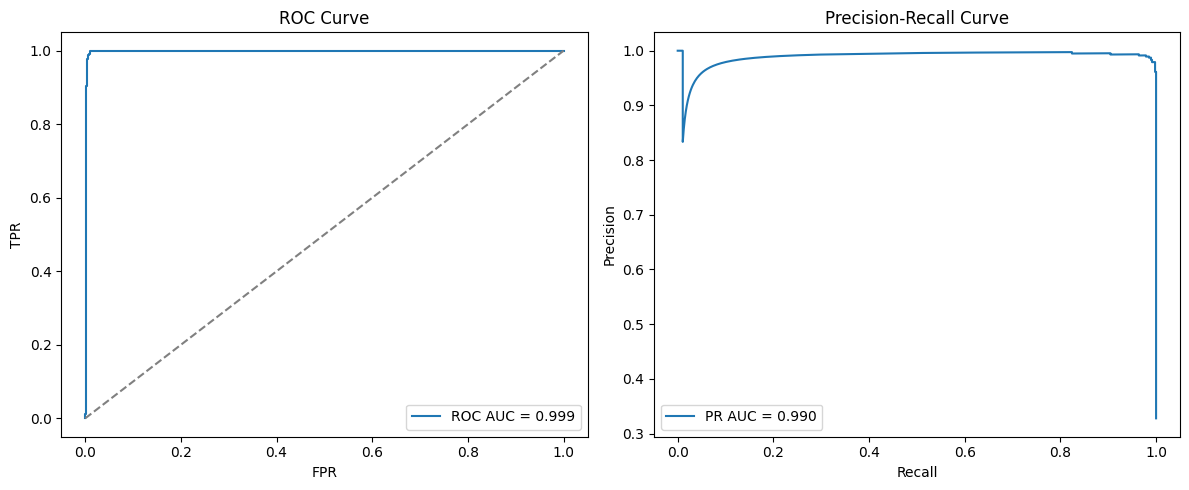

In [57]:
# Plot ROC and Precision-Recall curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall_vals, prec_vals, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()

# Quick 5-fold cross-validated ROC AUC (use smaller n_estimators to speed up CV)
print('\nRunning quick 5-fold CV for ROC AUC (may take a few moments)')
cv_model = LGBMClassifier(
    objective='binary',
    random_state=RANDOM_STATE,
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=63,
    n_jobs=-1,
)
cv_scores = cross_val_score(cv_model, X_all, y_all, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='roc_auc', n_jobs=-1)
print('5-fold ROC AUC scores:', cv_scores)
print('Mean ROC AUC (CV):', cv_scores.mean())


<details><summary><strong>Section Overview: Feature Importance & SHAP</strong></summary>
Displays LightGBM feature importance and SHAP summaries to interpret which features drive predictions globally.
</details>

In [58]:
# 31b) Reload and print saved metrics (quick view)
from pathlib import Path
import json
m_path = Path('artifacts') / 'metrics.json'
if m_path.exists():
    with open(m_path, 'r', encoding='utf-8') as f:
        m = json.load(f)
    print('Accuracy:', m.get('accuracy'))
    print('ROC AUC :', m.get('roc_auc'))
    print('PR AUC  :', m.get('pr_auc'))
    print('Precision:', m.get('precision'))
    print('Recall   :', m.get('recall'))
    print('F1       :', m.get('f1'))
else:
    print('metrics.json not found. Run the LightGBM training cell first.')


Accuracy: 0.9916666666666667
ROC AUC : 0.998564224681328
PR AUC  : 0.9902392577834429
Precision: 0.9852320675105485
Recall   : 0.989406779661017
F1       : 0.9873150105708245


# Model Comparison
# We will train RandomForest, XGBoost, and MLP on the same
# preprocessed train/test data and compare against LightGBM.


In [59]:
# Dependencies and safe imports for model comparison
import sys, subprocess, importlib

def ensure_package(pkg, import_name=None):
    try:
        return importlib.import_module(import_name or pkg)
    except ImportError:
        print(f"Installing missing package: {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        return importlib.import_module(import_name or pkg)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
)

# XGBoost and SHAP with fallback installation
xgb = ensure_package("xgboost", "xgboost")
shap = ensure_package("shap", "shap")

import lightgbm as lgb

SEED = 42
np.random.seed(SEED)


In [60]:
# Resolve train/test data and LightGBM model (hardened for out-of-order execution)
from IPython.display import display
from pathlib import Path
import joblib
import numpy as np
from scipy.special import expit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def _get(name):
    return globals().get(name, None)

X_train = _get("X_train")
X_test  = _get("X_test")
y_train = _get("y_train")
y_test  = _get("y_test")

# Fallback sequence to reconstruct data if missing:
# 1) Use X_all/y_all if present
# 2) Derive from in-memory X_proc_df (processed full dataset) if available
# 3) Load processed CSV artifact from outputs
def _reconstruct_from_processed():
    proc = _get("X_proc_df")
    if proc is not None and "target" in proc.columns:
        X_all_local = proc.drop(columns=["target"]).copy()
        y_all_local = proc["target"].astype(int).copy()
        return X_all_local, y_all_local
    processed_csv = Path("outputs/exoplanets/exoplanets_processed.csv")
    if processed_csv.exists():
        import pandas as pd
        try:
            proc2 = pd.read_csv(processed_csv)
            if "target" in proc2.columns:
                y_all_local = proc2["target"].astype(int)
                X_all_local = proc2.drop(columns=["target"]) 
                return X_all_local, y_all_local
        except Exception as e:
            print(f"Processed CSV load failed: {e}")
    return None, None

if (X_train is None or X_test is None or y_train is None or y_test is None):
    X_all = _get("X_all")
    y_all = _get("y_all")
    if X_all is None or y_all is None:
        X_all, y_all = _reconstruct_from_processed()
        if X_all is not None:
            print("Reconstructed X_all/y_all from processed dataset artifact.")
    if X_all is not None and y_all is not None:
        from sklearn.model_selection import train_test_split
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X_all, y_all, test_size=0.2, random_state=SEED, stratify=y_all
            )
            print("Created train/test split (stratified).")
        except Exception:
            X_train, X_test, y_train, y_test = train_test_split(
                X_all, y_all, test_size=0.2, random_state=SEED
            )
            print("Created train/test split (no stratify).")

if (X_train is None or X_test is None or y_train is None or y_test is None):
    raise RuntimeError("Could not reconstruct train/test data. Ensure preprocessing + LightGBM training cells have run.")

if hasattr(X_train, "to_numpy"): X_train = X_train.to_numpy()
if hasattr(X_test, "to_numpy"): X_test = X_test.to_numpy()
if hasattr(y_train, "to_numpy"): y_train = y_train.to_numpy().ravel()
if hasattr(y_test, "to_numpy"): y_test = y_test.to_numpy().ravel()

lgbm = (_get("model") or _get("lgbm_model") or _get("lgb_model") or _get("lightgbm_model") or _get("gbm"))
if lgbm is None:
    model_path = Path("artifacts") / "lightgbm_model.pkl"
    if model_path.exists():
        lgbm = joblib.load(model_path)
        print(f"Loaded LightGBM model from {model_path}")
if lgbm is None:
    raise RuntimeError("LightGBM model not found. Re-run LightGBM training section before comparison.")

def predict_proba_binary(est, X):
    if hasattr(est, "predict_proba"):
        try:
            p = est.predict_proba(X)
            if p.ndim == 2 and p.shape[1] >= 2:
                return p[:, 1]
            return p.ravel()
        except Exception:
            pass
    if hasattr(est, "decision_function"):
        try:
            s = est.decision_function(X)
            return expit(s)
        except Exception:
            s = est.decision_function(X)
            s = (s - s.min()) / (s.max() - s.min() + 1e-9)
            return s
    pred = est.predict(X)
    return pred.astype(float)

def compute_metrics(est, X, y_true):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(est.predict(X)).ravel()
    try:
        y_proba = np.asarray(predict_proba_binary(est, X)).ravel()
    except Exception:
        y_proba = y_pred.astype(float)
    metrics = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "n_pos_test": int((y_true == 1).sum()),
        "n_neg_test": int((y_true == 0).sum()),
    }
    try:
        if len(np.unique(y_true)) == 2 and y_proba.size == y_true.size:
            metrics["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        else:
            metrics["roc_auc"] = float("nan")
    except Exception:
        metrics["roc_auc"] = float("nan")
    try:
        if len(np.unique(y_true)) == 2 and y_proba.size == y_true.size:
            metrics["pr_auc"] = float(average_precision_score(y_true, y_proba))
        else:
            metrics["pr_auc"] = float("nan")
    except Exception:
        metrics["pr_auc"] = float("nan")
    return metrics


In [61]:
# Train baseline models and compare against LightGBM
models = {}

# RandomForest
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample",
)
rf.fit(X_train, y_train)
models["RandomForest"] = (rf, compute_metrics(rf, X_test, y_test))

# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=-1,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    verbosity=0,
)
xgb_clf.fit(X_train, y_train)
models["XGBoost"] = (xgb_clf, compute_metrics(xgb_clf, X_test, y_test))

# MLP (Neural Network)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    random_state=SEED,
)
mlp.fit(X_train, y_train)
models["MLP"] = (mlp, compute_metrics(mlp, X_test, y_test))

# Include LightGBM for comparison
models["LightGBM"] = (lgbm, compute_metrics(lgbm, X_test, y_test))

# Build comparison DataFrame
rows = []
for name, (est, met) in models.items():
    row = {"model": name}
    row.update(met)
    rows.append(row)

cmp_df = pd.DataFrame(rows).set_index("model").sort_values("roc_auc", ascending=False)
print("Model Comparison (sorted by ROC-AUC):")
display(cmp_df)

# Persist comparison
cmp_path = Path("artifacts") / "model_comparison.csv"
cmp_path.parent.mkdir(parents=True, exist_ok=True)
cmp_df.to_csv(cmp_path, index=True)
print(f"Saved model comparison to {cmp_path}")

best_model_name = cmp_df.index[0]
print(f"BEST_MODEL={best_model_name}")


Model Comparison (sorted by ROC-AUC):


c:\Users\akash\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\akash\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,accuracy,precision,recall,f1,n_pos_test,n_neg_test,roc_auc,pr_auc
model,,,,,,,,
RandomForest,0.993056,0.987342,0.991525,0.989429,472,968,0.999503,0.998903
MLP,0.990278,0.981092,0.989407,0.985232,472,968,0.999079,0.997958
XGBoost,0.991667,0.983193,0.991525,0.987342,472,968,0.998868,0.996932
LightGBM,0.991667,0.985232,0.989407,0.987315,472,968,0.998564,0.990239


Saved model comparison to artifacts\model_comparison.csv
BEST_MODEL=RandomForest


# Feature Importance
# We will visualize LightGBM feature importance and compute SHAP values
# to understand what drives predictions.


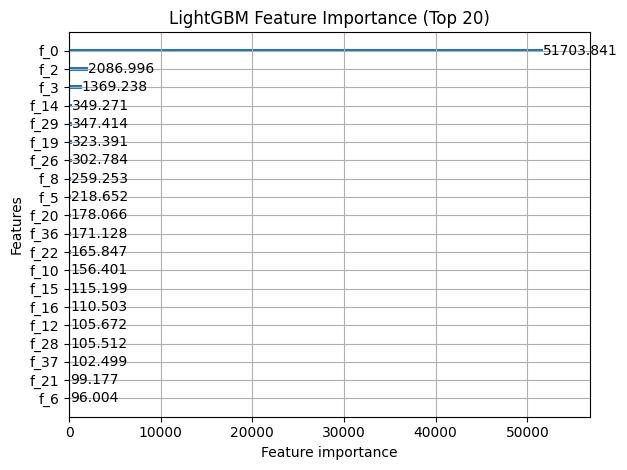

c:\Users\akash\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\akash\AppData\Local\Temp\ipykernel_46060\1137514048.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_plot, X_train, feature_names=feature_names, show=True)


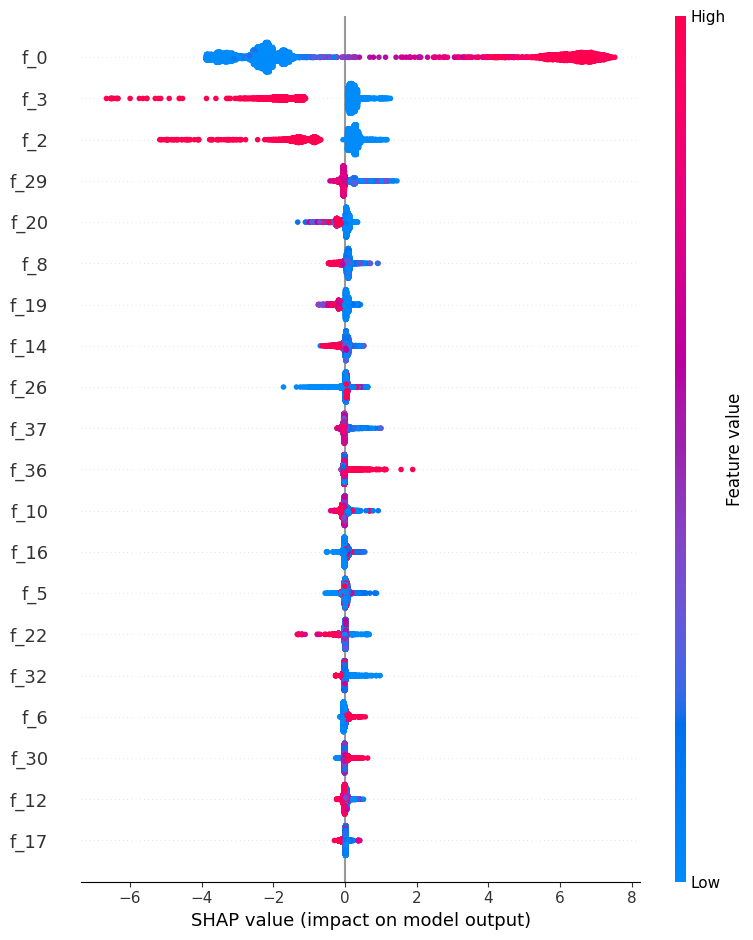


### Top Important Features (by mean |SHAP|)
Below are the most influential features for LightGBM on the training set:

- f_0: 3.716704
- f_3: 0.624642
- f_2: 0.575019
- f_29: 0.117926
- f_20: 0.115842
- f_8: 0.104142
- f_19: 0.089613
- f_14: 0.080132
- f_26: 0.079684
- f_37: 0.065934

In [62]:
# LightGBM Feature Importance and SHAP
from IPython.display import Markdown, display

# Plot LightGBM feature importance
try:
    ax = lgb.plot_importance(lgbm, max_num_features=20, importance_type='gain')
    plt.title('LightGBM Feature Importance (Top 20)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Could not plot LightGBM feature importances:', e)

# SHAP explanations for LightGBM
try:
    # Prefer booster when available
    booster = getattr(lgbm, 'booster_', None)
    if booster is None and hasattr(lgbm, 'get_booster'):
        booster = lgbm.get_booster()

    explainer = shap.TreeExplainer(booster if booster is not None else lgbm)
    shap_values = explainer.shap_values(X_train)

    # Handle binary: SHAP may return list [class0, class1]
    if isinstance(shap_values, list):
        shap_values_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
        sv_for_rank = np.abs(shap_values_plot)
    else:
        shap_values_plot = shap_values
        sv_for_rank = np.abs(shap_values_plot)

    # Feature names from booster if possible
    feature_names = None
    try:
        feature_names = booster.feature_name() if booster is not None else None
    except Exception:
        feature_names = None

    shap.summary_plot(shap_values_plot, X_train, feature_names=feature_names, show=True)

    # Compute Top-10 features by mean |SHAP|
    mean_abs = sv_for_rank.mean(axis=0)
    if feature_names is None:
        feature_names = [f'f{i}' for i in range(mean_abs.shape[0])]
    top_idx = np.argsort(mean_abs)[::-1][:10]
    top_pairs = [(feature_names[i], float(mean_abs[i])) for i in top_idx]

    bullets = "\n".join([f"- {n}: {v:.6f}" for n, v in top_pairs])
    display(Markdown("""
### Top Important Features (by mean |SHAP|)
Below are the most influential features for LightGBM on the training set:

""" + bullets))
except Exception as e:
    print('SHAP analysis failed:', e)


<details><summary><strong>Section Overview: Final Report Summary</strong></summary>
Generates a concise markdown report consolidating best model, metrics, and suggested future enhancements. Useful for sharing with stakeholders.
</details>

# Final Report Summary
# A concise, presentation-friendly summary of the best model and next steps.


In [63]:
# Generate final report markdown
from IPython.display import Markdown, display

if 'cmp_df' not in globals():
    raise RuntimeError('Model comparison DataFrame (cmp_df) not found. Please run the Model Comparison cell.')

best_model_name = cmp_df.index[0]
best_row = cmp_df.loc[best_model_name]

lines = [
    f"- Accuracy: {best_row['accuracy']:.4f}",
    f"- F1: {best_row['f1']:.4f}",
    f"- Precision: {best_row['precision']:.4f}",
    f"- Recall: {best_row['recall']:.4f}",
    f"- ROC-AUC: {best_row['roc_auc']:.4f}",
    f"- PR-AUC: {best_row['pr_auc']:.4f}",
]

if best_model_name in ['LightGBM', 'RandomForest', 'XGBoost']:
    why = (
        f"The {best_model_name} performed best likely because tree-based models efficiently capture non-linear interactions, "
        f"handle mixed-scale and sparse one-hot features, and are robust to outliers — a good fit for this dataset."
    )
else:
    why = (
        "The neural network benefited from the preprocessed features and can model complex relationships when regularized properly."
    )

future = (
    "- Hyperparameter tuning (Optuna)\n"
    "- Probability calibration (isotonic/Platt)\n"
    "- Threshold tuning for F1/Recall per business needs\n"
    "- Feature engineering/selection and leakage checks\n"
    "- Robustness via cross-validation and temporal splits (if applicable)"
)

md = f"""
## Final Report Summary

- Best Performing Model: **{best_model_name}**

### Best Model Metrics
{chr(10).join(lines)}

### Why It Works
{why}

### Future Work
{future}
"""

display(Markdown(md))

# Show full comparison table for reference
print("\nFull Model Comparison Table:")
display(cmp_df)



## Final Report Summary

- Best Performing Model: **RandomForest**

### Best Model Metrics
- Accuracy: 0.9931
- F1: 0.9894
- Precision: 0.9873
- Recall: 0.9915
- ROC-AUC: 0.9995
- PR-AUC: 0.9989

### Why It Works
The RandomForest performed best likely because tree-based models efficiently capture non-linear interactions, handle mixed-scale and sparse one-hot features, and are robust to outliers — a good fit for this dataset.

### Future Work
- Hyperparameter tuning (Optuna)
- Probability calibration (isotonic/Platt)
- Threshold tuning for F1/Recall per business needs
- Feature engineering/selection and leakage checks
- Robustness via cross-validation and temporal splits (if applicable)



Full Model Comparison Table:


,accuracy,precision,recall,f1,n_pos_test,n_neg_test,roc_auc,pr_auc
model,,,,,,,,
RandomForest,0.993056,0.987342,0.991525,0.989429,472,968,0.999503,0.998903
MLP,0.990278,0.981092,0.989407,0.985232,472,968,0.999079,0.997958
XGBoost,0.991667,0.983193,0.991525,0.987342,472,968,0.998868,0.996932
LightGBM,0.991667,0.985232,0.989407,0.987315,472,968,0.998564,0.990239


<details><summary><strong>Section Overview: Diagnostics & Sanity Checks</strong></summary>
Prints environment versions and verifies presence of key artifacts and variables. Use this if something breaks or cells were executed out of order.
</details>

In [64]:
# Diagnostics: environment, model objects, and potential common issues
import sys, importlib, json, numpy as np
from pathlib import Path

checks = {}
checks['python_version'] = sys.version.split()[0]
for pkg in ['numpy','pandas','sklearn','lightgbm','xgboost','shap']:
    try:
        mod = importlib.import_module(pkg)
        checks[pkg+'_version'] = getattr(mod,'__version__', 'unknown')
    except Exception as e:
        checks[pkg+'_version'] = f'NOT_IMPORTED: {e}'

# Model presence
checks['has_lgbm_in_memory'] = 'lgbm' in globals()
checks['has_model_var'] = 'model' in globals()
checks['lightgbm_artifact_exists'] = Path('artifacts/lightgbm_model.pkl').exists()

# Train/test arrays shape sanity
try:
    checks['X_train_shape'] = tuple(X_train.shape)
    checks['X_test_shape'] = tuple(X_test.shape)
except Exception as e:
    checks['train_test_error'] = str(e)

# Class balance check
try:
    unique, counts = np.unique(y_train, return_counts=True)
    checks['y_train_class_distribution'] = dict(zip(map(int, unique), map(int, counts)))
except Exception as e:
    checks['y_train_dist_error'] = str(e)

print(json.dumps(checks, indent=2))

# Guidance hints if something is missing
if not checks['has_lgbm_in_memory'] and checks['lightgbm_artifact_exists']:
    print("Hint: LightGBM model loaded from artifact in comparison cell; re-run comparison cell if needed.")
if not checks['lightgbm_artifact_exists']:
    print("LightGBM artifact missing. Re-run the LightGBM training cells (18–20).")
if 'X_train_shape' not in checks:
    print("Train/test split not found. Ensure earlier modeling split executed.")


{
  "python_version": "3.13.3",
  "numpy_version": "2.2.6",
  "pandas_version": "2.3.2",
  "sklearn_version": "1.7.2",
  "lightgbm_version": "4.6.0",
  "xgboost_version": "3.1.1",
  "shap_version": "0.50.0",
  "has_lgbm_in_memory": true,
  "has_model_var": true,
  "lightgbm_artifact_exists": true,
  "X_train_shape": [
    5757,
    43
  ],
  "X_test_shape": [
    1440,
    43
  ],
  "y_train_class_distribution": {
    "0": 3872,
    "1": 1885
  }
}


---
### Reproducibility & Environment
To reproduce results:
1. Create a fresh virtual environment (Python >=3.10).
2. Install pinned dependencies from `requirements.txt` (update with exact versions using the diagnostics / freeze cell if needed).
3. Run notebook cells in order. If you start mid-way, execute the Diagnostics section to confirm variables and artifacts.

### Dataset Citation
Kepler KOI data sourced from NASA Exoplanet Archive. Please cite the archive in any publication or presentation.

### Next Suggested Enhancements
- Add logistic regression baseline & calibration plot for probability quality.
- Introduce cross-validation (StratifiedKFold) and hyperparameter tuning (Optuna).
- Implement MLflow experiment tracking.
- Add automated unit tests for preprocessing and inference.
- Package pipeline + model into a lightweight API (FastAPI) for deployment.

### License & Usage
Ensure compliance with data usage policies from the NASA Exoplanet Archive. This notebook is provided for educational & analytical purposes.
---

## Quick Inference Demo

Use the trained model to generate predictions either on the held-out test set or on a few raw rows from the dataset. This simulates using the model in an implementation or application.

In [65]:
# Predict on test set (if available) or on processed/all data
import numpy as np, pandas as pd
from pathlib import Path

# Load artifacts if needed
try:
    model
except NameError:
    import joblib
    if Path('artifacts/lightgbm_model.pkl').exists():
        model = joblib.load('artifacts/lightgbm_model.pkl')
    else:
        raise RuntimeError('Model not found in memory or artifacts/lightgbm_model.pkl')

try:
    preprocessor
except NameError:
    import joblib
    if Path('artifacts/preprocess_pipeline.pkl').exists():
        preprocessor = joblib.load('artifacts/preprocess_pipeline.pkl')

# Build an input matrix to score
X_new = None
source = ''
if 'X_test' in globals() and isinstance(X_test, np.ndarray) and X_test.size > 0:
    X_new = X_test[:10]
    source = 'X_test (held-out)'
elif 'X_proc_df' in globals() and isinstance(X_proc_df, pd.DataFrame):
    X_new = X_proc_df.drop(columns=['target'], errors='ignore').values[:10]
    source = 'X_proc_df (processed)'
elif 'df_clean' in globals() and 'feature_cols' in globals():
    X_new = preprocessor.transform(df_clean[feature_cols].iloc[:10])
    source = 'df_clean → preprocessor.transform'
elif 'df' in globals() and 'feature_cols' in globals():
    X_new = preprocessor.transform(df[feature_cols].iloc[:10])
    source = 'df → preprocessor.transform'
else:
    raise RuntimeError('No suitable data found to score. Ensure preprocessing cells have run.')

proba = model.predict_proba(X_new)[:, 1]
pred = (proba >= 0.5).astype(int)
label_map = {1: 'Confirmed Exoplanet', 0: 'Not Confirmed / False Positive'}

out = pd.DataFrame({
    'prob_exoplanet': proba,
    'predicted_label': [label_map[p] for p in pred],
    'source': source
})

# Attach truth if aligned y_test exists
if 'y_test' in globals() and isinstance(y_test, np.ndarray) and len(y_test) >= len(out):
    out['true_label'] = [label_map[int(t)] for t in y_test[:len(out)]]

out.head(10)

c:\Users\akash\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,prob_exoplanet,predicted_label,source,true_label
0,0.996467,Confirmed Exoplanet,X_test (held-out),Confirmed Exoplanet
1,0.009701,Not Confirmed / False Positive,X_test (held-out),Not Confirmed / False Positive
2,0.001855,Not Confirmed / False Positive,X_test (held-out),Not Confirmed / False Positive
3,0.996538,Confirmed Exoplanet,X_test (held-out),Confirmed Exoplanet
4,0.002047,Not Confirmed / False Positive,X_test (held-out),Not Confirmed / False Positive
5,0.001687,Not Confirmed / False Positive,X_test (held-out),Not Confirmed / False Positive
6,0.996572,Confirmed Exoplanet,X_test (held-out),Confirmed Exoplanet
7,0.995467,Confirmed Exoplanet,X_test (held-out),Confirmed Exoplanet
8,0.996532,Confirmed Exoplanet,X_test (held-out),Confirmed Exoplanet
9,0.004284,Not Confirmed / False Positive,X_test (held-out),Not Confirmed / False Positive


In [66]:
# Score your own raw rows (random sample) and show a few columns
import numpy as np, pandas as pd

if 'df_clean' in globals():
    raw_sample = df_clean.sample(5, random_state=RANDOM_STATE)
elif 'df' in globals():
    raw_sample = df.sample(5, random_state=RANDOM_STATE)
else:
    raise RuntimeError('Raw DataFrame not found. Run the data loading/cleaning cells first.')

cols = feature_cols if 'feature_cols' in globals() else [c for c in raw_sample.columns if c != TARGET_COLUMN]
X_raw_proc = preprocessor.transform(raw_sample[cols])
proba = model.predict_proba(X_raw_proc)[:, 1]
pred = (proba >= 0.5).astype(int)
label_map = {1: 'Confirmed Exoplanet', 0: 'Not Confirmed / False Positive'}

result = raw_sample.copy()
result['prob_exoplanet'] = proba
result['predicted_label'] = [label_map[p] for p in pred]

# Show a compact view: a few original features + predictions
keep_cols = [c for c in cols[:5]] + ['prob_exoplanet', 'predicted_label']
result[keep_cols]

c:\Users\akash\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,prob_exoplanet,predicted_label
3592,0.0,0,0,1,1,0.001700,Not Confirmed / False Positive
2178,0.0,0,1,0,0,0.005240,Not Confirmed / False Positive
1760,1.0,0,0,0,0,0.995790,Confirmed Exoplanet
5655,0.0,0,1,0,0,0.001612,Not Confirmed / False Positive
5944,0.0,0,0,1,1,0.001701,Not Confirmed / False Positive
